In [53]:
import os
from copy import deepcopy
from datetime import datetime
from os import listdir

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import yaml
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
plt.rcParams["figure.figsize"] = [16,9]

In [3]:
def get_conf(conf_path):
    """Reads configuration file"""
    with open(rf'{conf_path}') as conf_file:
        conf = yaml.safe_load(conf_file)
        return conf

In [4]:
def SMAPE(forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    if len(actual.shape)!=2:
        actual = actual.reshape(actual.shape[0],1)
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2

    smape_score = str(round(sum(diff/avg)/len(forecast) * 100, 2))

    print('SMAPE Error Score: ' + smape_score + ' %')
    return smape_score

In [5]:
def plot_pred_vs_act(actual, predicted, model_type):
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.title(f'Predicted vs Actual Sales for {model_type} Model')

In [6]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [7]:
def xboost(xgb_params, xgb_model_dir, x_train=None, y_train=None, x_test=None, y_test=None, training_req=1):
    """Trains xgboost model and returns it"""

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    file_name = f'xgb_model_{folder_name}.json'

    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, label=y_test, feature_names=list(x_test.columns))

    if training_req:

        params = {'max_depth':xgb_params['XGB_MAX_DEPTH'],
                  'eta':xgb_params['XGB_ETA'],
                  'silent':xgb_params['XGB_SILENT'],
                'subsample':xgb_params['XGB_SUBSAMPLE']}
        num_rounds = xgb_params['XGB_NUM_ROUNDS']

        xgb_model = xgb.train(params, dtrain, num_rounds)

        # save
        xgb_model.save_model(xgb_model_dir+file_name)

    else:
        sorted_xgb_models = [x for x in listdir(xgb_model_dir) if 'xgb_' in str(x)]
        sorted_xgb_models.sort(reverse=True)
        xgb_model = xgb.Booster()
        xgb_model.load_model(xgb_model_dir+str(sorted_xgb_models[0]))


    return xgb_model, dtest

In [8]:
def lstm_model(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        mdl = Sequential()

        mdl.add(LSTM(params['LSTM_NODES'],
                     # activation='relu',
                     input_shape=(x_train.shape[1], x_train.shape[2]),
                     # unroll=True
                     )
                )

        # mdl.add(Dropout(0.5))

        # mdl.add(LSTM(params['LSTM_NODES']//2,
        #              activation='relu',
        #              return_sequences=False
        #              )
        #         )

        mdl.add(Dense(1))

        mdl.compile(loss='mse', optimizer='adam')

        mdl.summary()

        lstm_history = mdl.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            batch_size=90,
            callbacks=callback,
            verbose=True
        )

        mdl.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        mdl = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return mdl


In [9]:
def lstm_model_v2(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        model_lstm.add(Dropout(0.5))
        model_lstm.add(LSTM(params['LSTM_NODES']//2, activation='relu', return_sequences=False))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=False)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return model_lstm


In [10]:
def lstm_model_v3(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        mdl = Sequential()

        mdl.add(LSTM(params['LSTM_NODES'],
                     activation='relu',
                     batch_input_shape=(params['LSTM_BATCH_SIZE'],x_train.shape[1], x_train.shape[2]),
                     stateful=True,
                     return_sequences=True
                     )
                )

        mdl.add(Dropout(0.5))

        mdl.add(LSTM(params['LSTM_NODES']//2,
                     activation='relu',
                     return_sequences=False
                     )
                )

        mdl.add(Dense(1))

        mdl.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))

        mdl.summary()

        lstm_history = mdl.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )

        mdl.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        mdl = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return mdl

In [11]:
def read_data(path, date_index_col, numeric_cols=None):
    if path:
        df = pd.read_csv(path, index_col=date_index_col, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index)
        if numeric_cols:
            for col in numeric_cols:
                df[col] = df[col].astype('int16')
        return df

In [12]:
# Prepare data by aggregating according to config
def data_preprocessing(data, grouped_cols, label_col, date_col='date'):
    # Rearrange dataset so we can apply shift methods
    data = data.reset_index()
    data = data.sort_values(date_col).groupby(grouped_cols, as_index=False)
    data = data.agg({f'{label_col}':['mean']})
    data.columns = grouped_cols + [label_col]
    return data


In [13]:
def xgboost_data_preprocessing(data_in,date_col):

    data = deepcopy(data_in)
    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col])
    data['year'] = data[date_col].dt.year
    data['quarter'] = data[date_col].dt.quarter
    data['month'] = data[date_col].dt.month
    data['weekofyear'] = data[date_col].dt.weekofyear
    data['weekday'] = data[date_col].dt.weekday
    data['dayofweek'] = data[date_col].dt.dayofweek


    return data

In [14]:
def feature_engineering(data_in,date_col) -> pd.DataFrame:

    data = deepcopy(data_in)
    data.index = pd.DatetimeIndex(data[date_col])

    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col], infer_datetime_format=True)
    data['year'] = data[date_col].dt.year.astype('float32')
    data['quarter'] = data[date_col].dt.quarter.astype('float32')
    data['month'] = data[date_col].dt.month.astype('float32')
    data['weekofyear'] = data.index.isocalendar().week.astype('float32')
    data['dayofweek'] = data[date_col].dt.dayofweek.astype('float32')
    data.drop(f'{date_col}', axis=1, inplace=True)
    data.reset_index(inplace=True)


    return data

In [76]:
def series_to_supervised(data, index, target, categories, lookback=1, lag=1, dropnan=True):
    """Transform the data into a time series problem"""

    # data = deepcopy(data_in)

    # Drop index column from data
    if index in data.columns:
        data.drop(f'{index}', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(lookback, 0, -1):
        cols.append(data.shift(i))
        names += [f'{col}(t-{i})' for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [f'{col}(t+{lag})' for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1, join='inner')
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    # Drop rows with different item or store values than the shifted columns
    last_cols_for_categories = [f'{x}(t-{lookback})' for x in categories]

    for cat in last_cols_for_categories:
        col = cat.split('(')[0] # example - item
        agg = agg[(agg[f'{col}(t+{lag})'] == agg[cat])]

    return agg

In [16]:
def split_train_valid(data, label, test_size, lag):

    # Label
    labels_col = f'{label}(t+{lag})'
    labels = data[labels_col]
    data = data.drop([x for x in data.columns if '+' in str(x)], axis=1)

    X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels.values, test_size=test_size, shuffle=False)

    return X_train, Y_train, X_valid, Y_valid

In [17]:
def split_xy(data, data_cols, label_col):
    # labels_col = f'{label}(t+{lag})'
    label_pos = data_cols.index(label_col) + 1
    col_len = len(data_cols)
    act_len = col_len-1 #Removing index
    label_index = data.shape[1] - (act_len - label_pos) - 2
    labels = data[:,label_index]
    data = data[:,:data.shape[1] - act_len] #Removing target columns
    return data,labels

In [18]:
def reshape_features(X_train,X_valid):
    X_train_series = X_train.reshape((X_train.shape[0], 30, 3))
    X_valid_series = X_valid.reshape((X_valid.shape[0], 30, 3))
    return X_train_series, X_valid_series

In [19]:
def data_scaler(data, scaled, inverse=False, model=None):
    if scaled:
        fitted_scaler = joblib.load(OBJECTS_DIR+model+SCALER_FILE)

        if inverse:
            inv_scaled_data = fitted_scaler.inverse_transform(data)
            return inv_scaled_data
        else:
            scaled_data = fitted_scaler.transform(data)
            return scaled_data

    else:
        scaler = StandardScaler()
        # num_cols = [x for x in data.columns if num_col in x]
        scaled_data = scaler.fit_transform(data)
        joblib.dump(scaler, OBJECTS_DIR+model+SCALER_FILE)
        return scaled_data

In [20]:
def category_wise_split_train_eval(data, categories, eval_len):
    split_train = []
    split_test = []
    for i, frame in data.groupby(categories):
        split_train.append(frame[:-eval_len])
        split_test.append(frame[-eval_len:])

    train = pd.concat(split_train, axis=0)
    eval = pd.concat(split_test, axis=0)

    return train, eval

In [21]:
MAIN_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])
RAW_DATA_DIR = os.path.join(MAIN_DIR, 'data', 'raw', 'store_item', '')
PROCESSED_DATA_DIR = os.path.join(MAIN_DIR, 'data','processed', '')
MODEL_DIR = os.path.join(MAIN_DIR, 'models', '')
OBJECTS_DIR = os.path.join(MAIN_DIR, 'objects', '')
CONFIGS_PATH = os.path.join(MAIN_DIR, 'configs', 'config.yaml')
conf = get_conf(CONFIGS_PATH)

SCALER_FILE = 'lag1_scaler_info.save'
TRAIN_PATH = RAW_DATA_DIR + 'train.csv'
TEST_PATH = RAW_DATA_DIR + 'test.csv'
PROCESSED_PATH = PROCESSED_DATA_DIR + 'data.csv'

NP_ARRAYS_NAMES = ['X_train_series', 'Y_train', 'X_valid_series', 'Y_valid']

plt.rcParams["figure.figsize"] = [16,9]

In [22]:
# Read Training and Testing data
train = read_data(TRAIN_PATH, 0, conf['NUMERIC_COLS'])
test = read_data(TEST_PATH, 1)

In [23]:
train

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [24]:
test

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1
...,...,...,...
2018-03-27,44995,10,50
2018-03-28,44996,10,50
2018-03-29,44997,10,50


<h1> LSTM </h1>

In [25]:
train_set, eval_set = category_wise_split_train_eval(train, conf['CATEGORIES'], eval_len=360)

In [26]:
train_set

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-01-01,10,50,69
2017-01-02,10,50,40
2017-01-03,10,50,63


In [27]:
eval_set

,store,item,sales
date,,,
2017-01-06,1,1,24
2017-01-07,1,1,14
2017-01-08,1,1,20
2017-01-09,1,1,18
2017-01-10,1,1,11
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [28]:
# # Prepare train data for lstm by aggregating
# preprocessed_data = data_preprocessing(train,
#                                        conf['GROUPED_COLS'],
#                                        conf['LABEL_COL'],
#                                        conf['INDEX_COL']
#                                        )

In [29]:
# Convert data into format fit for LSTM
seq_train_set = series_to_supervised(train_set,
                                             index=conf['INDEX_COL'],
                                             target=conf['LABEL_COL'],
                                             categories=conf['CATEGORIES'],
                                             lookback=conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                             lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                             )

In [30]:
seq_train_set

,store(t-29),item(t-29),sales(t-29),store(t-28),item(t-28),sales(t-28),store(t-27),item(t-27),sales(t-27),store(t-26),...,sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+1),item(t+1),sales(t+1)
date,,,,,,,,,,,,,,,,,,,,,
2013-01-30,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,11.0,1.0,1.0,6.0,1,1,9,1.0,1.0,13.0
2013-01-31,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,...,6.0,1.0,1.0,9.0,1,1,13,1.0,1.0,11.0
2013-02-01,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,...,9.0,1.0,1.0,13.0,1,1,11,1.0,1.0,21.0
2013-02-02,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,...,13.0,1.0,1.0,11.0,1,1,21,1.0,1.0,15.0
2013-02-03,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,...,11.0,1.0,1.0,21.0,1,1,15,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,10.0,50.0,88.0,10.0,50.0,81.0,10.0,50.0,70.0,10.0,...,68.0,10.0,50.0,63.0,10,50,64,10.0,50.0,69.0
2017-01-01,10.0,50.0,81.0,10.0,50.0,70.0,10.0,50.0,58.0,10.0,...,63.0,10.0,50.0,64.0,10,50,69,10.0,50.0,40.0
2017-01-02,10.0,50.0,70.0,10.0,50.0,58.0,10.0,50.0,55.0,10.0,...,64.0,10.0,50.0,69.0,10,50,40,10.0,50.0,63.0


In [31]:
# Convert data into format fit for LSTM
seq_eval_set = series_to_supervised(eval_set,
                                     index=conf['INDEX_COL'],
                                     target=conf['LABEL_COL'],
                                     categories=conf['CATEGORIES'],
                                     lookback=conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                     lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                     )

In [32]:
seq_eval_set

,store(t-29),item(t-29),sales(t-29),store(t-28),item(t-28),sales(t-28),store(t-27),item(t-27),sales(t-27),store(t-26),...,sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+1),item(t+1),sales(t+1)
date,,,,,,,,,,,,,,,,,,,,,
2017-02-04,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,...,17.0,1.0,1.0,24.0,1,1,25,1.0,1.0,25.0
2017-02-05,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,...,24.0,1.0,1.0,25.0,1,1,25,1.0,1.0,16.0
2017-02-06,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,...,25.0,1.0,1.0,25.0,1,1,16,1.0,1.0,12.0
2017-02-07,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,25.0,1.0,1.0,16.0,1,1,12,1.0,1.0,20.0
2017-02-08,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,...,16.0,1.0,1.0,12.0,1,1,20,1.0,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,10.0,50.0,75.0,10.0,50.0,68.0,10.0,50.0,76.0,10.0,...,76.0,10.0,50.0,51.0,10,50,41,10.0,50.0,63.0
2017-12-27,10.0,50.0,68.0,10.0,50.0,76.0,10.0,50.0,73.0,10.0,...,51.0,10.0,50.0,41.0,10,50,63,10.0,50.0,59.0
2017-12-28,10.0,50.0,76.0,10.0,50.0,73.0,10.0,50.0,66.0,10.0,...,41.0,10.0,50.0,63.0,10,50,59,10.0,50.0,74.0


In [33]:
# Scale data for training
train_scaled = data_scaler(seq_train_set, scaled=0, model='lstm')
eval_scaled = data_scaler(seq_eval_set, scaled=1, model='lstm')

In [34]:
train_scaled

array([[-1.56669831, -1.69774924, -1.35233411, ..., -1.56670267,
        -1.69775396, -1.36444792],
       [-1.56669831, -1.69774924, -1.4240023 , ..., -1.56670267,
        -1.69775396, -1.43626791],
       [-1.56669831, -1.69774924, -1.31650002, ..., -1.56670267,
        -1.69775396, -1.07716797],
       ...,
       [ 1.56670267,  1.69775396,  0.69020925, ...,  1.56669831,
         1.69774924,  0.43105177],
       [ 1.56670267,  1.69775396,  0.26020012, ...,  1.56669831,
         1.69774924,  0.43105177],
       [ 1.56670267,  1.69775396,  0.15269784, ...,  1.56669831,
         1.69774924,  0.57469175]])

In [35]:
eval_scaled

array([[-1.56669831, -1.69774924, -0.95815908, ..., -1.56670267,
        -1.69775396, -0.93352799],
       [-1.56669831, -1.69774924, -1.31650002, ..., -1.56670267,
        -1.69775396, -1.25671794],
       [-1.56669831, -1.69774924, -1.10149546, ..., -1.56670267,
        -1.69775396, -1.40035791],
       ...,
       [ 1.56670267,  1.69775396,  0.90521382, ...,  1.56669831,
         1.69774924,  0.8260617 ],
       [ 1.56670267,  1.69775396,  0.79771154, ...,  1.56669831,
         1.69774924,  0.39514178],
       [ 1.56670267,  1.69775396,  0.54687288, ...,  1.56669831,
         1.69774924,  1.11334165]])

In [1]:
# Split train eval into x & y
x_train, y_train = split_xy(train_scaled, conf['DATA_COLS'], conf['LABEL_COL'])
x_eval, y_eval = split_xy(eval_scaled, conf['DATA_COLS'], conf['LABEL_COL'])

NameError: name 'split_xy' is not defined

In [37]:
# Reshape data for training
x_train_reshaped, x_eval_reshaped = reshape_features(x_train, x_eval)

In [38]:
x_train

array([[-1.56669831, -1.69774924, -1.35233411, ..., -1.56669831,
        -1.69774924, -1.50804559],
       [-1.56669831, -1.69774924, -1.4240023 , ..., -1.56669831,
        -1.69774924, -1.36440794],
       [-1.56669831, -1.69774924, -1.31650002, ..., -1.56669831,
        -1.69774924, -1.43622677],
       ...,
       [ 1.56670267,  1.69775396,  0.69020925, ...,  1.56670267,
         1.69775396, -0.39485377],
       [ 1.56670267,  1.69775396,  0.26020012, ...,  1.56670267,
         1.69775396,  0.43106275],
       [ 1.56670267,  1.69775396,  0.15269784, ...,  1.56670267,
         1.69775396,  0.43106275]])

In [39]:
x_train_reshaped.shape

(718499, 30, 3)

In [40]:
y_train_reshaped, y_eval_reshaped = y_train.reshape((y_train.shape[0], 1)), y_eval.reshape((y_eval.shape[0], 1))

In [41]:
# Obtain trained LSTM model
model_lstm = lstm_model(conf['LSTM_PARAMS'],
                        MODEL_DIR,
                        x_train_reshaped,
                        y_train_reshaped,
                        x_eval_reshaped,
                        y_eval_reshaped,
                        training_req=0
                        )

In [42]:
# # Split into train-test set
# X_train, Y_train, X_valid, Y_valid = split_train_valid(lstm_processed_data_2,
#                                                        test_size=0.2,
#                                                        lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
#                                                        )

In [43]:
# # Scale data for training
# X_train_scaled = data_scaler(X_train, scaled=0, model='lstm')
# X_valid_scaled = data_scaler(X_valid, scaled=1, model='lstm')

In [44]:

# make a prediction
pred = model_lstm.predict(x_eval_reshaped)
# eval_x = x_eval_reshaped.reshape((x_eval_reshaped.shape[0], 30*3))
# invert scaling for forecast

5172/5172 [==============================] - 11s 2ms/step


In [45]:
eval_with_pred = np.concatenate((eval_scaled[:,:-1], pred), axis=1)
eval_with_pred = data_scaler(eval_with_pred, scaled=1, inverse=True, model='lstm')

In [46]:
eval_with_pred

array([[ 1.        ,  1.        , 24.        , ...,  1.        ,
         1.        , 21.09601092],
       [ 1.        ,  1.        , 14.        , ...,  1.        ,
         1.        , 13.7038884 ],
       [ 1.        ,  1.        , 20.        , ...,  1.        ,
         1.        , 16.6796064 ],
       ...,
       [10.        , 50.        , 76.        , ..., 10.        ,
        50.        , 67.66978047],
       [10.        , 50.        , 73.        , ..., 10.        ,
        50.        , 71.78576491],
       [10.        , 50.        , 66.        , ..., 10.        ,
        50.        , 74.8278099 ]])

In [47]:
seq_eval_set

,store(t-29),item(t-29),sales(t-29),store(t-28),item(t-28),sales(t-28),store(t-27),item(t-27),sales(t-27),store(t-26),...,sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+1),item(t+1),sales(t+1)
date,,,,,,,,,,,,,,,,,,,,,
2017-02-04,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,...,17.0,1.0,1.0,24.0,1,1,25,1.0,1.0,25.0
2017-02-05,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,...,24.0,1.0,1.0,25.0,1,1,25,1.0,1.0,16.0
2017-02-06,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,...,25.0,1.0,1.0,25.0,1,1,16,1.0,1.0,12.0
2017-02-07,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,25.0,1.0,1.0,16.0,1,1,12,1.0,1.0,20.0
2017-02-08,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,...,16.0,1.0,1.0,12.0,1,1,20,1.0,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,10.0,50.0,75.0,10.0,50.0,68.0,10.0,50.0,76.0,10.0,...,76.0,10.0,50.0,51.0,10,50,41,10.0,50.0,63.0
2017-12-27,10.0,50.0,68.0,10.0,50.0,76.0,10.0,50.0,73.0,10.0,...,51.0,10.0,50.0,41.0,10,50,63,10.0,50.0,59.0
2017-12-28,10.0,50.0,76.0,10.0,50.0,73.0,10.0,50.0,66.0,10.0,...,41.0,10.0,50.0,63.0,10,50,59,10.0,50.0,74.0


In [48]:
inv_pred = eval_with_pred[:,-1].reshape(-1,1)
inv_eval_y = seq_eval_set.iloc[:,-1].values.reshape(-1,1)
lstm_smape = SMAPE(inv_pred, inv_eval_y)

SMAPE Error Score: 12.69 %


In [49]:
# LSTM Evaluation - MSE
lstm_mse = model_lstm.evaluate(x_eval_reshaped,eval_scaled[:,-1].reshape(-1,1))

5172/5172 [==============================] - 13s 2ms/step - loss: 0.0983


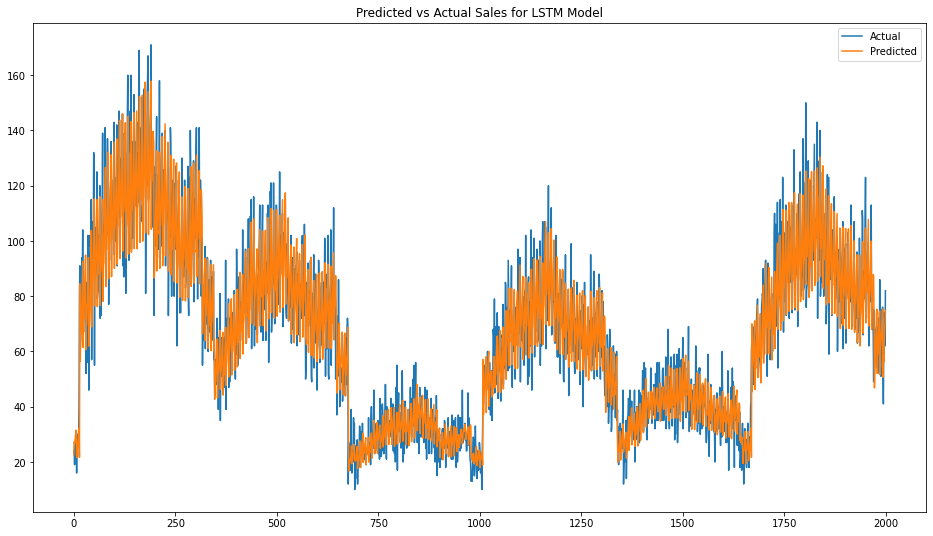

In [54]:
plot_pred_vs_act(inv_eval_y[-2000:],inv_pred[-2000:],'LSTM')

In [55]:
pred_df = pd.DataFrame(eval_with_pred, columns=seq_eval_set.columns, index=seq_eval_set.index)
pred_df

,store(t-29),item(t-29),sales(t-29),store(t-28),item(t-28),sales(t-28),store(t-27),item(t-27),sales(t-27),store(t-26),...,sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+1),item(t+1),sales(t+1)
date,,,,,,,,,,,,,,,,,,,,,
2017-02-04,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,...,17.0,1.0,1.0,24.0,1.0,1.0,25.0,1.0,1.0,21.096011
2017-02-05,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,...,24.0,1.0,1.0,25.0,1.0,1.0,25.0,1.0,1.0,13.703888
2017-02-06,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,...,25.0,1.0,1.0,25.0,1.0,1.0,16.0,1.0,1.0,16.679606
2017-02-07,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,25.0,1.0,1.0,16.0,1.0,1.0,12.0,1.0,1.0,16.504783
2017-02-08,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,...,16.0,1.0,1.0,12.0,1.0,1.0,20.0,1.0,1.0,17.714297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,10.0,50.0,75.0,10.0,50.0,68.0,10.0,50.0,76.0,10.0,...,76.0,10.0,50.0,51.0,10.0,50.0,41.0,10.0,50.0,56.160520
2017-12-27,10.0,50.0,68.0,10.0,50.0,76.0,10.0,50.0,73.0,10.0,...,51.0,10.0,50.0,41.0,10.0,50.0,63.0,10.0,50.0,63.754111
2017-12-28,10.0,50.0,76.0,10.0,50.0,73.0,10.0,50.0,66.0,10.0,...,41.0,10.0,50.0,63.0,10.0,50.0,59.0,10.0,50.0,67.669780


In [51]:
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [56]:
# # LSTM Evaluation - SMAPE
# lstm_pred = model_lstm.predict(X_valid_series)
# lstm_smape = SMAPE(lstm_pred, Y_valid)

In [57]:
# # LSTM Evaluation - MSE
# lstm_mse = model_lstm.evaluate(X_valid_series, Y_valid)

In [58]:

# unshaped_x_valid = X_valid_series.reshape(-1,conf['LSTM_PARAMS']['WIND'])

In [ ]:
# forecast_set = series_to_supervised(train_set[-],
#                                      index=conf['INDEX_COL'],
#                                      target=conf['LABEL_COL'],
#                                      categories=conf['CATEGORIES'],
#                                      lookback=conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
#                                      lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
#                                      )

In [ ]:
# PREDICTING NEXT 90 DAYS

In [88]:
# Get last n days of data for each item store to create first data point to predict
# This predicted data point will be added to previous 30-i records to create prediction sequence for next ith label
till_n_set, from_n_set = category_wise_split_train_eval(train, conf['CATEGORIES'], eval_len=(120+1))
from_n_set

,store,item,sales
date,,,
2017-09-02,1,1,26
2017-09-03,1,1,23
2017-09-04,1,1,12
2017-09-05,1,1,26
2017-09-06,1,1,24
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [89]:
ith_prediction_row = series_to_supervised(from_n_set,
                                     index=conf['INDEX_COL'],
                                     target=conf['LABEL_COL'],
                                     categories=conf['CATEGORIES'],
                                     lookback=conf['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                     lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                     )

In [90]:
ith_prediction_row

,store(t-29),item(t-29),sales(t-29),store(t-28),item(t-28),sales(t-28),store(t-27),item(t-27),sales(t-27),store(t-26),...,sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+1),item(t+1),sales(t+1)
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,1.0,1.0,26.0,1.0,1.0,23.0,1.0,1.0,12.0,1.0,...,28.0,1.0,1.0,30.0,1,1,21,1.0,1.0,12.0
2017-10-02,1.0,1.0,23.0,1.0,1.0,12.0,1.0,1.0,26.0,1.0,...,30.0,1.0,1.0,21.0,1,1,12,1.0,1.0,18.0
2017-10-03,1.0,1.0,12.0,1.0,1.0,26.0,1.0,1.0,24.0,1.0,...,21.0,1.0,1.0,12.0,1,1,18,1.0,1.0,15.0
2017-10-04,1.0,1.0,26.0,1.0,1.0,24.0,1.0,1.0,29.0,1.0,...,12.0,1.0,1.0,18.0,1,1,15,1.0,1.0,20.0
2017-10-05,1.0,1.0,24.0,1.0,1.0,29.0,1.0,1.0,28.0,1.0,...,18.0,1.0,1.0,15.0,1,1,20,1.0,1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,10.0,50.0,75.0,10.0,50.0,68.0,10.0,50.0,76.0,10.0,...,76.0,10.0,50.0,51.0,10,50,41,10.0,50.0,63.0
2017-12-27,10.0,50.0,68.0,10.0,50.0,76.0,10.0,50.0,73.0,10.0,...,51.0,10.0,50.0,41.0,10,50,63,10.0,50.0,59.0
2017-12-28,10.0,50.0,76.0,10.0,50.0,73.0,10.0,50.0,66.0,10.0,...,41.0,10.0,50.0,63.0,10,50,59,10.0,50.0,74.0


<h1> XGBoost </h1>

In [26]:
xgb_data = xgboost_data_preprocessing(preprocessed_data, conf['INDEX_COL'])

C:\Users\yashc\AppData\Local\Temp\ipykernel_20440\4087673004.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['weekofyear'] = data[date_col].dt.weekofyear


In [27]:
# Preprocess data to perform aggregation
xgb_train_x, xgb_test_x, xgb_train_y, xgb_test_y = train_test_split(
    xgb_data.drop([f'{conf["INDEX_COL"]}', f'{conf["LABEL_COL"]}'],axis=1),
    xgb_data[conf["LABEL_COL"]],
    test_size=0.2
)

In [28]:
# Train XGBoost model
xgb_model, xgb_test_data = xboost(conf['XGB_PARAMS'],
                                  MODEL_DIR,
                                  xgb_train_x,
                                  xgb_train_y,
                                  xgb_test_x,
                                  xgb_test_y,
                                  training_req=0
                                  )

In [29]:
# Get predictions from XGBoost model
xgb_predictions = pd.Series(xgb_model.predict(xgb_test_data))

# Transform predictions and actual data for SMAPE
xgb_predictions_reshaped = np.array(xgb_predictions).reshape(len(xgb_predictions),1)
xgb_test_y_reshaped = np.array(xgb_test_y).reshape(len(xgb_test_y),1)

In [30]:
# Get SMAPE for XGBoost
xgb_smape = SMAPE(xgb_predictions_reshaped, xgb_test_y_reshaped)

SMAPE Error Score: 15.27 %


In [31]:
# MSE Computation
xgb_mse = MSE(xgb_test_y_reshaped, xgb_predictions_reshaped)

<h1> Comparing the models' metrics </h1>

In [32]:
print(f'XGB SMAPE- {xgb_smape}%')
print(f'LSTM SMAPE- {lstm_smape}%')

print(f'XGB MSE- {xgb_mse:.2f}')
print(f'LSTM MSE- {lstm_mse:.2f}')

XGB SMAPE- 15.27%
LSTM SMAPE- 28.37%
XGB MSE- 68.24
LSTM MSE- 334.85


In [33]:
X_valid_series[0].transpose()

array([[25., 30., 16., 21., 21., 23., 26., 18., 29., 24., 21., 15., 23.,
        25., 22., 30., 20., 32., 25., 22., 35., 30., 44., 21., 22., 21.,
        23., 31., 36., 29.]])

In [34]:
Y_valid[0]

35.0

In [35]:
preprocessed_data

,item,store,date,sales
0,1,1,2013-01-01,13.0
1,1,1,2013-01-02,11.0
2,1,1,2013-01-03,14.0
3,1,1,2013-01-04,13.0
4,1,1,2013-01-05,10.0
...,...,...,...,...
912995,50,10,2017-12-27,63.0
912996,50,10,2017-12-28,59.0
912997,50,10,2017-12-29,74.0
912998,50,10,2017-12-30,62.0


In [36]:
preprocessed_data.iloc[-30:]

,item,store,date,sales
912970,50,10,2017-12-02,49.0
912971,50,10,2017-12-03,75.0
912972,50,10,2017-12-04,54.0
912973,50,10,2017-12-05,68.0
912974,50,10,2017-12-06,60.0
912975,50,10,2017-12-07,66.0
912976,50,10,2017-12-08,67.0
912977,50,10,2017-12-09,69.0
912978,50,10,2017-12-10,69.0
912979,50,10,2017-12-11,54.0
